## Resource Model metrics and comparisons

Work with Arches-based resource models (RM)

Load libraries

In [2]:
import os
import urllib.request
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re

Load GitHub repository and requirements

In [3]:
# Download and install latest version of Arches graph parser
!rm cultural-heritage -R
!git clone https://github.com/achp-project/cultural-heritage.git
!pip install -r cultural-heritage/graph-parser/requirements.txt

rm: cannot remove 'cultural-heritage': No such file or directory
Cloning into 'cultural-heritage'...
remote: Enumerating objects: 1806, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1806 (delta 247), reused 176 (delta 158), pack-reused 1527
Receiving objects: 100% (1806/1806), 20.69 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (1160/1160), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0

List of available RMs

In [4]:
# Download uploaded cultural heritage partners graphs
remote_source_files = {
    "MAPSS": "https://raw.githubusercontent.com/achp-project/prj-mapss/main/pkg/graphs/Heritage%20Place%20(3).json",
    "MAHS": "https://raw.githubusercontent.com/achp-project/prj-mahs/main/Site.json",
    "MAHSA": "https://raw.githubusercontent.com/achp-project/prj-mahsa/main/resource-models/Heritage%20Location%20Resource%20Model.json",
    "MAEASAM": "https://raw.githubusercontent.com/achp-project/prj-maeasam/main/Site.json",
    "EAMENA": "https://raw.githubusercontent.com/achp-project/prj-eamena-marea/main/resource_models/Heritage%20Place.json",
}

Select two or more RMs to compare (checkoxes). Choose: MAHSA and EAMENA.

In [5]:
def generate_checkboxes_from_dict(input_dict):
    checkboxes = {key: widgets.Checkbox(description=key, value=False) for key in input_dict.keys()}
    return checkboxes
checkboxes_dict = generate_checkboxes_from_dict(remote_source_files)
def get_and_print_checked_values(**kwargs):
    checked_values = {key: value for key, value in kwargs.items() if isinstance(value, widgets.Checkbox) and value.value}
interactive_widget = interactive(get_and_print_checked_values, **checkboxes_dict)
display(interactive_widget)
print("Note: MAHSA and EAMENA have been hard coded below, please select these two ones")

interactive(children=(Checkbox(value=False, description='MAPSS'), Checkbox(value=False, description='MAHS'), C…

Note: MAHSA and EAMENA have been hard coded below, please select these two ones


Retrieve and show selected RM keys

In [6]:
selected_keys = []
for key, checkbox in checkboxes_dict.items():
    if checkbox.value:
        selected_keys.append(key)
print("Selected projects:", selected_keys)
if len(selected_keys) < 2:
    print("Please select a minimum of two different JSON files")
else:
    subset_remote_source_files = {}
    # Iterate through the selected keys and add corresponding key-value pairs to the subset dictionary
    for key in selected_keys:
        if key in remote_source_files:
            subset_remote_source_files[key] = remote_source_files[key]
    print("Selected RMs:", subset_remote_source_files)

!rm inputResourceModels -R
!mkdir -p inputResourceModels

for (project_name, resource_model_url) in subset_remote_source_files.items():
  target_filename = f"{project_name}_{resource_model_url.split('/')[-1]}"
  # print(target_filename)
  urllib.request.urlretrieve(resource_model_url, filename=f"inputResourceModels/{target_filename}")

Selected projects: ['MAHSA', 'EAMENA']
Selected RMs: {'MAHSA': 'https://raw.githubusercontent.com/achp-project/prj-mahsa/main/resource-models/Heritage%20Location%20Resource%20Model.json', 'EAMENA': 'https://raw.githubusercontent.com/achp-project/prj-eamena-marea/main/resource_models/Heritage%20Place.json'}
rm: cannot remove 'inputResourceModels': No such file or directory


Create subgraph and comparison dataframe csv files by running [graph-parser.py](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/graph_parser.py) and [graph-comparator.py](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/graph_comparator.py)

In [7]:
!python cultural-heritage/graph-parser/graph_comparator.py -d -m list -o subgraphMetrics.csv inputResourceModels/*.json
!python cultural-heritage/graph-parser/graph_comparator.py -d -m compare -o comparisonMetrics.csv inputResourceModels/*.json
# Generate pandas Dataframes from csv
subgraph_metrics = pd.read_csv('subgraphMetrics.csv')
comparison_metrics = pd.read_csv('comparisonMetrics.csv')

Show subgraph metrics (see: [documentation](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/README.md#minimal_subgraph_data))

In [118]:
subgraph_metrics = pd.read_csv('subgraphMetrics.csv')
col_order = ['G', 'source', 'target', 'property', 'source_id', 'target_id']
subgraph_metrics.rename(columns={'graph_name': 'G', 'source_property': 'source', 'target_property': 'target', 'relation_type': 'property'}, inplace=True)
subgraph_metrics['source_id'] = subgraph_metrics['source'] + '_' + subgraph_metrics['G']
subgraph_metrics['target_id'] = subgraph_metrics['target'] + '_' + subgraph_metrics['G']
subgraph_metrics = subgraph_metrics[col_order]
subgraph_metrics

,G,source,target,property,source_id,target_id
0,EAMENA_Heritage%20Place,E27_Site,E53_Place,P53_has_former_or_current_location,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place
1,EAMENA_Heritage%20Place,E27_Site,E53_Place,P53_has_former_or_current_location,E27_Site_EAMENA_Heritage%20Place,E53_Place_EAMENA_Heritage%20Place
2,EAMENA_Heritage%20Place,E54_Dimension,E60_Number,P90_has_value,E54_Dimension_EAMENA_Heritage%20Place,E60_Number_EAMENA_Heritage%20Place
3,EAMENA_Heritage%20Place,E54_Dimension,E60_Number,P90_has_value,E54_Dimension_EAMENA_Heritage%20Place,E60_Number_EAMENA_Heritage%20Place
4,EAMENA_Heritage%20Place,E54_Dimension,E60_Number,P90_has_value,E54_Dimension_EAMENA_Heritage%20Place,E60_Number_EAMENA_Heritage%20Place
...,...,...,...,...,...,...
321,MAHSA_Heritage%20Location%20Resource%20Model,E14_Condition_Assessment,E3_Condition_State,P35_has_identified,E14_Condition_Assessment_MAHSA_Heritage%20Loca...,E3_Condition_State_MAHSA_Heritage%20Location%2...
322,MAHSA_Heritage%20Location%20Resource%20Model,E14_Condition_Assessment,E3_Condition_State,P35_has_identified,E14_Condition_Assessment_MAHSA_Heritage%20Loca...,E3_Condition_State_MAHSA_Heritage%20Location%2...
323,MAHSA_Heritage%20Location%20Resource%20Model,E18_Physical_Thing,E18_Physical_Thing,L54_is_same-as,E18_Physical_Thing_MAHSA_Heritage%20Location%2...,E18_Physical_Thing_MAHSA_Heritage%20Location%2...
324,MAHSA_Heritage%20Location%20Resource%20Model,E13_Attribute_Assignment,E39_Actor,P14_carried_out_by,E13_Attribute_Assignment_MAHSA_Heritage%20Loca...,E39_Actor_MAHSA_Heritage%20Location%20Resource...


Compararison metrics (see: [documentation](https://github.com/achp-project/cultural-heritage/blob/main/graph-parser/README.md#graph_comparison_data))

In [119]:
comparison_metrics = pd.read_csv('comparisonMetrics.csv')
comparison_metrics.rename(columns={'graph_name': 'G', 'source_property': 'source', 'target_property': 'target', 'relation_type': 'property'}, inplace=True)
comparison_metrics['G'] = 'both' # comparison_metrics['graph_name_1'] + "_x_" + comparison_metrics['graph_name_2']
comparison_metrics['source_id'] = comparison_metrics['source'] + '_' + comparison_metrics['G']
comparison_metrics['target_id'] = comparison_metrics['target'] + '_' + comparison_metrics['G']
comparison_metrics = comparison_metrics[col_order]
comparison_metrics

,G,source,target,property,source_id,target_id
0,both,E54_Dimension,E60_Number,P90_has_value,E54_Dimension_both,E60_Number_both
1,both,E3_Condition_State,E5_Event,O14i_is_initialized_by,E3_Condition_State_both,E5_Event_both
2,both,E16_Measurement,E55_Type,P2_has_type,E16_Measurement_both,E55_Type_both
3,both,E13_Attribute_Assignment,E52_Time-Span,P4_has_time-span,E13_Attribute_Assignment_both,E52_Time-Span_both
4,both,E16_Measurement,E54_Dimension,P40_observed_dimension,E16_Measurement_both,E54_Dimension_both
5,both,E53_Place,E55_Type,P2_has_type,E53_Place_both,E55_Type_both
6,both,E52_Time-Span,E61_Time_Primitive,P82a_begin_of_the_begin,E52_Time-Span_both,E61_Time_Primitive_both
7,both,E53_Place,E44_Place_Appellation,P87_is_identified_by,E53_Place_both,E44_Place_Appellation_both
8,both,E13_Attribute_Assignment,E55_Type,P141_assigned,E13_Attribute_Assignment_both,E55_Type_both
9,both,E52_Time-Span,E61_Time_Primitive,P82b_end_of_the_end,E52_Time-Span_both,E61_Time_Primitive_both


### Graphs



Graph graphical parameters, complete dataframe and functions

In [121]:
node_size = 200
font_size = 10
edge_width = .5
fig_dim = 10
node_color = "#add8e6" # lightblue

subgraph_metrics['weight'] = edge_width
comparison_metrics['weight'] = edge_width * 2

# Concatenation of subgraphs and comparison metrics and drops duplicates.Get subgraphs in both RM, and remove duplicated subgraphs
df_all_match = pd.concat([subgraph_metrics, comparison_metrics])
df_all_match = df_all_match.drop_duplicates()
df_all_match_copy = df_all_match.copy() # deep copy
df_all_match_copy['uniq'] = df_all_match_copy['source'] + "_" + df_all_match_copy['property'] + df_all_match_copy['target'] # field with unique id
# get 'both' rows in a separated df
df_both = df_all_match_copy.loc[df_all_match_copy['G'] == 'both'] # both dataframe
both_uniq = list(set(df_both['uniq'])) # get uniq ID in the 'both' dataframe
df_all_match_copy = df_all_match_copy[~df_all_match_copy['uniq'].isin(both_uniq)] # drop both from the main dataframe
df_all_complete = pd.concat([df_both, df_all_match_copy])

def create_graph(rm):
  # filter on graph label
  # condition = df_all_match['G'] == rm
  # condition = df_all_match['G'] in rm
  # df_G = df_all_match[condition]
  df_G = df_all_match[df_all_match.G.isin([rm])]
  G = nx.from_pandas_edgelist(df_G, 'source_id', 'target_id', True, create_using=nx.DiGraph())
  G_attrs_nodes = {}
  # clean
  rm_ = '_' + rm
  for i, node in enumerate(G.nodes()):
    a = re.sub(rm_, '', node)
    G_attrs_nodes[node] = {'entity': a, 'G': rm}
  nx.set_node_attributes(G, G_attrs_nodes)
  return(G)

def edges_labels(dict):
    newdict = {}
    for ed, value in dict.items():
      # short the name
      val = re.sub(r'_.*', '',  value)
      newdict[ed] = val
    return(newdict)

def nodes_labels(dict):
    newdict = {}
    for node, value in dict.items():
      # short the name
      val = re.sub(r'_.*', '',  value)
      newdict[node] = val
    return(newdict)

def plot_G(digraph):
  p = nx.circular_layout(digraph)
  labels_nodes = nx.get_node_attributes(digraph, 'entity')
  labels_nodes = nodes_labels(labels_nodes)
  labels_edges = nx.get_edge_attributes(digraph, 'property')
  labels_edges = edges_labels(labels_edges)
  plt.figure(figsize = (fig_dim + 6, fig_dim - 1))
  nx.draw(digraph, pos = p, labels = labels_nodes, with_labels = True, node_size = node_size, node_color = node_color, font_size = font_size, width = edge_width)
  nx.draw_networkx_edge_labels(digraph, pos = p, edge_labels = labels_edges, font_size = font_size)
  plt.show()

Plot individual graphs

EAMENA_Heritage%20Place


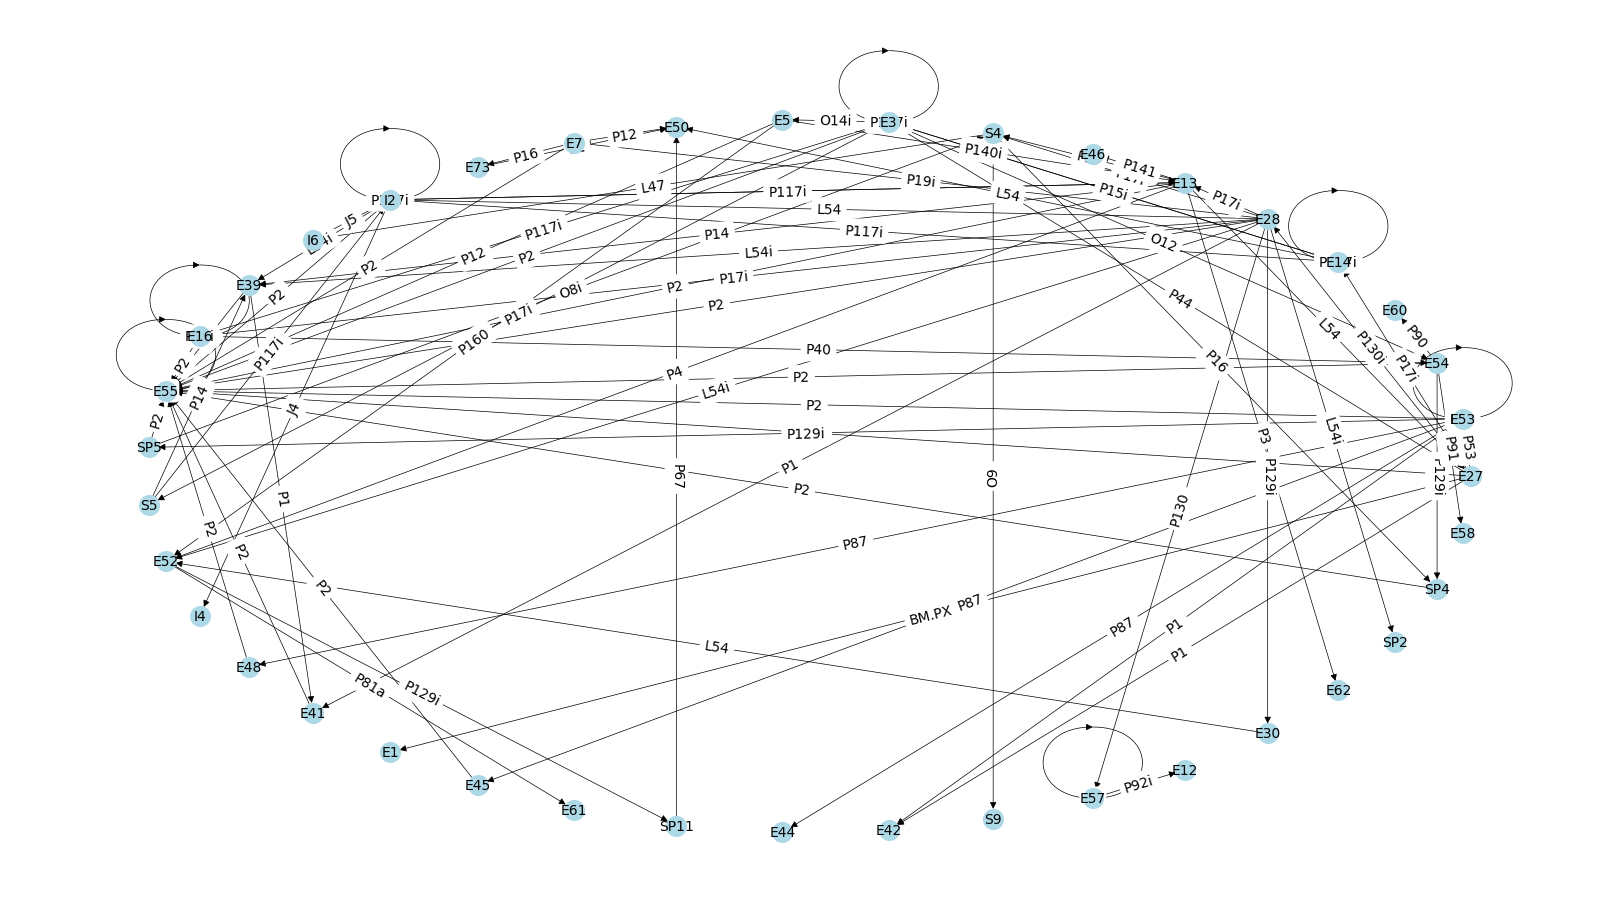

MAHSA_Heritage%20Location%20Resource%20Model


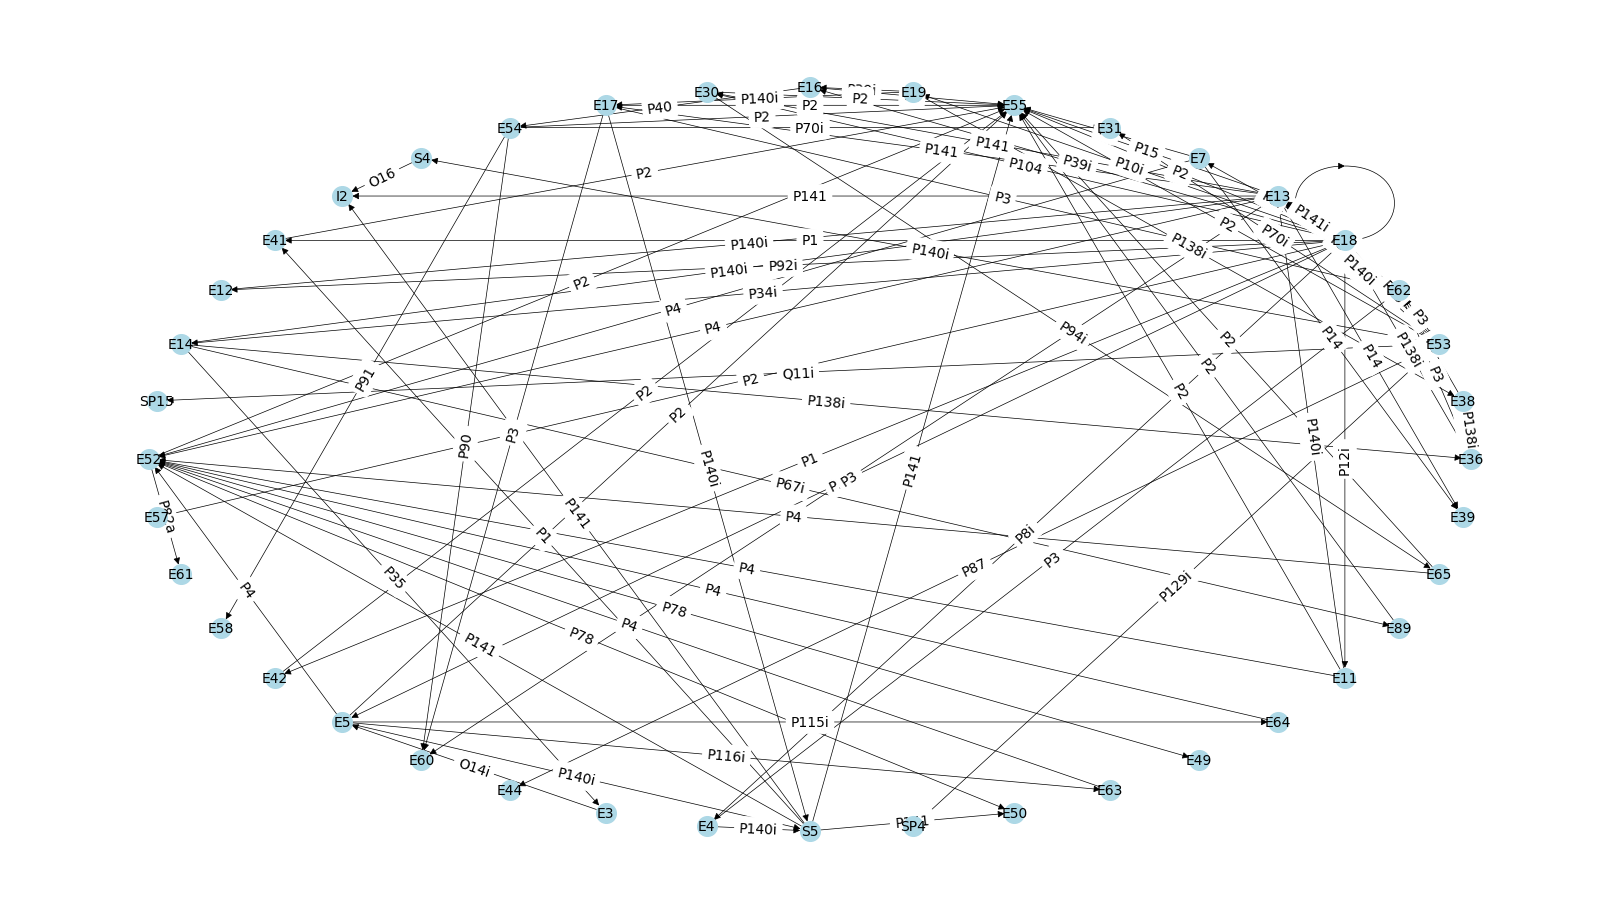

both


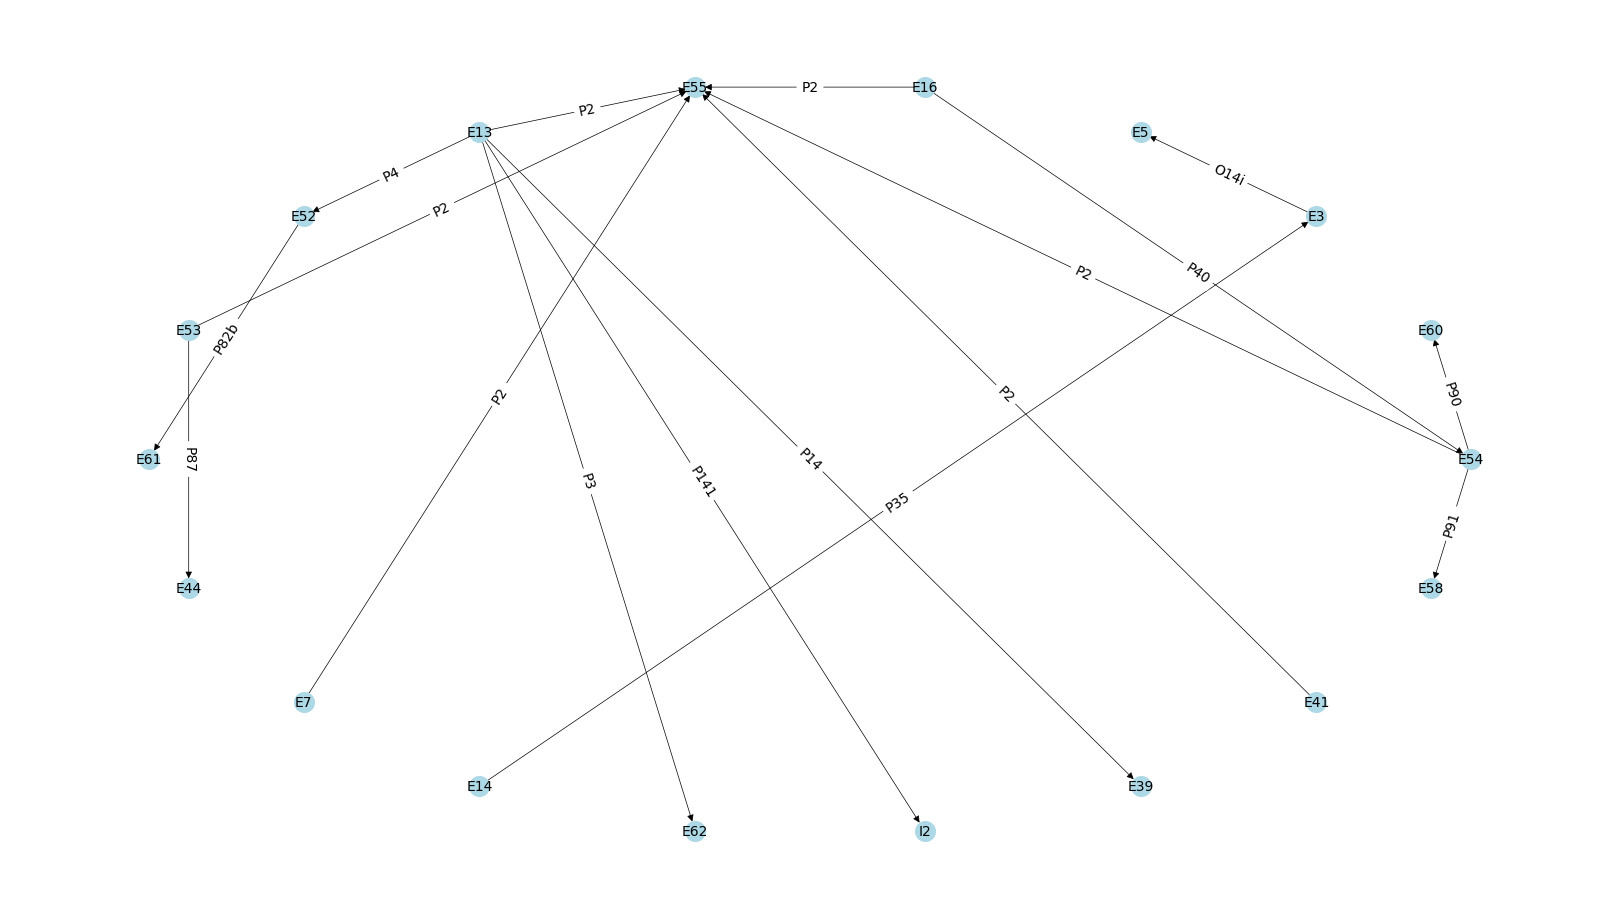

In [122]:
# graph_list = []
a = df_all_match['G'].unique()
a = a.tolist()
for i in a:
  print(i)
  G = create_graph(i)
  # graph_list.append(G)
  plot_G(G)

Plot combined graphs

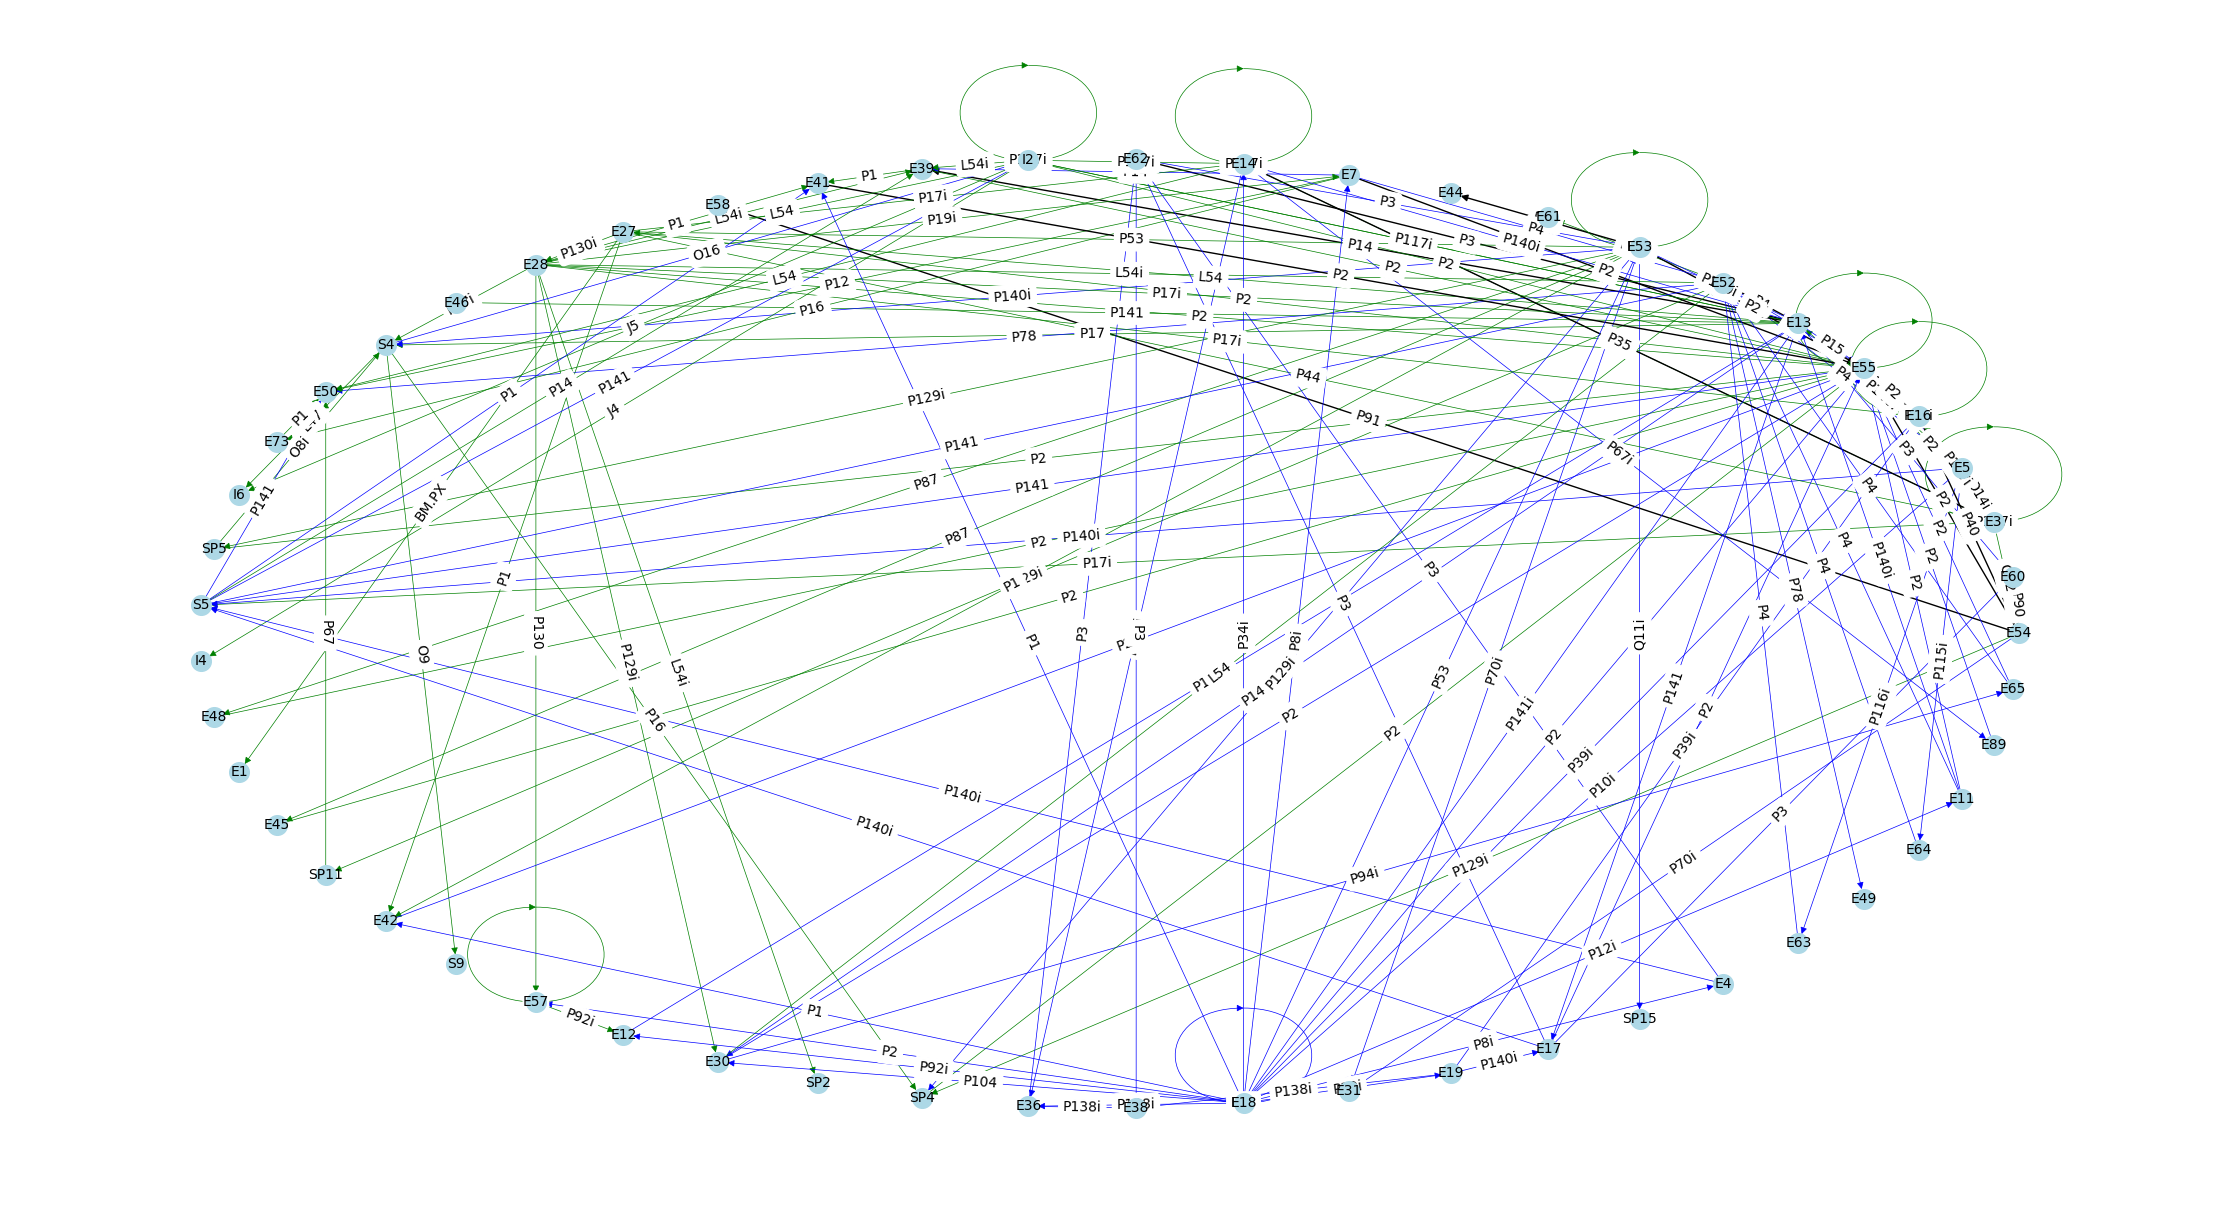

In [123]:
# assign colors
boths = df_all_complete['G'].unique().tolist()
boths.remove('both')
boths.append('both')
colors = ['green', 'blue', 'red', 'yellow', 'purple']
colors = colors[0:len(boths)-1]
colors.append('black')
df = pd.DataFrame(list(zip(boths, colors)),
               columns =['G', 'color'])
df_all_complete = df_all_complete.merge(df, left_on='G', right_on='G')

# load with attributes
G = nx.from_pandas_edgelist(df_all_complete, 'source', 'target', True, create_using=nx.DiGraph())
for i in G.nodes():
     G.nodes[i]['entity'] = re.sub(r'_.*', '',  i)

edges = G.edges()
colors = list(nx.get_edge_attributes(G,'color').values())
weights = list(nx.get_edge_attributes(G,'weight').values())

p = nx.circular_layout(G)
labels_nodes = nx.get_node_attributes(G, 'entity')
labels_nodes = nodes_labels(labels_nodes)
labels_edges = nx.get_edge_attributes(G, 'property')
labels_edges = edges_labels(labels_edges)
plt.figure(figsize = (fig_dim + 12, fig_dim + 2))
nx.draw(G, pos=p, labels = labels_nodes, with_labels = True, node_size = node_size, node_color = node_color, font_size = font_size, edge_color=colors, width=weights)
nx.draw_networkx_edge_labels(G, pos=p, edge_labels = labels_edges)
plt.show()

In [ ]:
# TODO
# Plot it in an interactive window, see: https://pyvis.readthedocs.io/en/latest/tutorial.html?highlight=jupyter#using-pyvis-within-jupyter-notebook

# !pip install pyvis
import pyvis
from pyvis import network as net

# errors, see: https://stackoverflow.com/questions/74945655/dataspell-outputs-the-following-error-local-cdn-resources-have-problems-on-chro
g = net.Network(notebook = True, cdn_resources='remote')
nxg = nx.complete_graph(5)
g.from_nx(nxg)
g.show("example.html")

example.html


example.html
